In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"US/Eastern\"")

In [ ]:
hex_project_id = _hex_json.loads("\"89a34800-5c26-407c-a942-c2fc4000ff84\"")

In [ ]:
hex_project_name = _hex_json.loads("\"DSBA6276_ClusterAnalysis\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

## Load and Clean Dataframe

In [ ]:
#Import necessary packages 
import pandas as pd 
import random 
import seaborn as sns 
import matplotlib.pyplot as plt 
import math

In [ ]:
#Load First Dataframe with Transaction Data
df_tran = pd.read_excel("99Bikers.xlsx", sheet_name="Transactions")
#Changing 'online_order' to boolean
df_tran["online_order"] = df_tran["online_order"].astype("bool")
#Dropping irrelevant columns
df_tran = df_tran.drop(['product_first_sold_date'], axis='columns')

#Handling Missing Data

na_val = ['online_order', 'brand', 'product_line', 'product_class', 'product_size', 'standard_cost']
# We will fill 'brand' with 'Solex', the mode
df_tran['brand'] = df_tran['brand'].fillna('Solex')
# Replacing half of missing values with True and the other half with False since the split is pretty even
nans = df_tran['online_order'].isna()
length = sum(nans)
replacement = random.choices([False, True], weights=[.5, .5], k=length)
df_tran.loc[nans,'online_order'] = replacement
# Replacing null values in 'product' columns with their mode
product_info = ['product_line', 'product_class', 'product_size']
mode = df_tran[product_info].mode()
df_tran[product_info] = df_tran[product_info].fillna(mode.iloc[0])
# Replacing null values in 'standard_cost' with mean
df_tran['standard_cost'] = df_tran['standard_cost'].fillna(df_tran['standard_cost'].mean())

In [ ]:
#Import Second Dataframe with Customer Demographic Data
df_cd = pd.read_excel("99Bikers.xlsx", sheet_name="CustomerDemographic")

# Dropping these random variables that have zero explanation or aren't relevant
df_cd = df_cd.drop(['first_name', 'last_name', 'job_title', 'wealth_segment',
                    'deceased_indicator', 'default'], axis='columns')

#Drop Rows where Gender is not Female or Male
df_cd = df_cd[df_cd.gender != "F"]
df_cd = df_cd[df_cd.gender != "U"]
df_cd = df_cd[df_cd.gender != "Femal"]
df_cd = df_cd[df_cd.gender != "M"]

# Filling 'job_industry_category' missing values with 'Other'
df_cd['job_industry_category'] = df_cd['job_industry_category'].fillna('Other')

# Since DOB can't be imputed, we'll drop rows with missing DOB
df_cd = df_cd.dropna(subset='DOB')

# I want to get people's ages as of December 31, 2017 (since we will be analyzing data from that year)
# This way I can group customer's by age later

# The format for DOB is YYYY-MM-DD
from  datetime import date, datetime

curr_date = '2017-12-31'
date_format = '%Y-%m-%d'
date_obj = datetime.strptime(curr_date, date_format)

df_cd["DOB"] = pd.to_datetime(df_cd["DOB"])
df_cd["AgeDays"] = date_obj - df_cd["DOB"]
df_cd["age"] = df_cd["AgeDays"].dt.days.astype("int16") // 365
df_cd = df_cd.drop(['AgeDays'], axis='columns')

# We have values below 0 which make no sense, removing any age less than 0
# Dropping ages less than 0
df_cd = df_cd.drop(df_cd[df_cd['age'] < 0].index)

def get_age_group(age):
    if age < 18:
        return 'Child'
    elif age >= 18 and age < 30:
        return 'Young_Adult'
    elif age >= 30 and age < 65:
        return 'Adult'
    elif age > 65:
        return 'Senior'

df_cd['Age_Group'] = df_cd['age'].apply(get_age_group)

/tmp/ipykernel_12/535193243.py:10: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_cd = pd.read_excel("99Bikers.xlsx", sheet_name="CustomerDemographic")


In [ ]:
#Display Dataframe Information
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    20000 non-null  int64         
 1   product_id        20000 non-null  int64         
 2   customer_id       20000 non-null  int64         
 3   transaction_date  20000 non-null  datetime64[ns]
 4   online_order      20000 non-null  object        
 5   order_status      20000 non-null  object        
 6   brand             20000 non-null  object        
 7   product_line      20000 non-null  object        
 8   product_class     20000 non-null  object        
 9   product_size      20000 non-null  object        
 10  list_price        20000 non-null  float64       
 11  standard_cost     20000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 1.8+ MB


### Prepare Dataframe for Cluster Analysis

In [ ]:
#Merge transaction data and customer demographics
df_new_all = pd.merge(df_cd,df_tran, on='customer_id', how='left')
#Drop unimportant columns
df_cluster_trans = df_new_all.drop(["DOB","transaction_id","product_id"],axis =1)

#Since some customers haven't had a purchase in 2017, we replace missing values with placeholders
df_cluster_trans["transaction_date"] = df_cluster_trans["transaction_date"].dt.month
df_cluster_trans["transaction_date"] = df_cluster_trans["transaction_date"].fillna(0)
df_cluster_trans["transaction_date"] = df_cluster_trans["transaction_date"].astype(str)
df_cluster_trans["list_price"] = df_cluster_trans["list_price"].fillna(0)
df_cluster_trans["standard_cost"] = df_cluster_trans["standard_cost"].fillna(0)
df_cluster_trans["brand"] = df_cluster_trans["brand"].fillna("No Brand")
df_cluster_trans["online_order"] = df_cluster_trans["online_order"].fillna("No Order")
df_cluster_trans["order_status"] = df_cluster_trans["order_status"].fillna("No Order Status")
df_cluster_trans["product_line"] = df_cluster_trans["product_line"].fillna("No Product Line")
df_cluster_trans["product_class"] = df_cluster_trans["product_class"].fillna("No Product Class")
df_cluster_trans["product_size"] = df_cluster_trans["product_size"].fillna("No Product Size")

#Create a copy of the dataframe 
df_cluster = df_cluster_trans
df_cluster1 = df_cluster_trans
df = df_cluster_trans
df

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,owns_car,tenure,age,Age_Group,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,2,Male,81,Financial Services,Yes,16.0,37,Adult,5.0,True,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82
1,2,Male,81,Financial Services,Yes,16.0,37,Adult,6.0,False,Approved,WeareA2B,Standard,medium,medium,752.64,205.36
2,2,Male,81,Financial Services,Yes,16.0,37,Adult,8.0,False,Approved,WeareA2B,Standard,medium,medium,1992.93,762.63
3,3,Male,61,Property,Yes,15.0,63,Adult,2.0,False,Approved,Giant Bicycles,Standard,medium,small,1311.44,1167.18
4,3,Male,61,Property,Yes,15.0,63,Adult,9.0,False,Approved,Giant Bicycles,Standard,medium,large,1635.30,993.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20009,3995,Male,93,Manufacturing,Yes,14.0,42,Adult,0.0,No Order,No Order Status,No Brand,No Product Line,No Product Class,No Product Size,0.00,0.00
20010,3996,Female,8,Health,No,19.0,42,Adult,0.0,No Order,No Order Status,No Brand,No Product Line,No Product Class,No Product Size,0.00,0.00
20011,3997,Female,87,Manufacturing,Yes,1.0,16,Child,0.0,No Order,No Order Status,No Brand,No Product Line,No Product Class,No Product Size,0.00,0.00
20012,3999,Male,11,Manufacturing,Yes,10.0,44,Adult,0.0,No Order,No Order Status,No Brand,No Product Line,No Product Class,No Product Size,0.00,0.00


# Cluster Analysis

In [ ]:
!pip install yellowbrick

In [ ]:
import numpy as np 
from scipy import stats
from sklearn.preprocessing import LabelEncoder

df = df.dropna()

# create a set storing outliers
outliers = set()

# calculate z_scores for numerical
scores = pd.DataFrame(columns = ['customer_id', 'past_3_years_bike_related_purchases', 'tenure', 'age','list_price', "standard_cost"])
scores['customer_id'] = df['customer_id']
for var in ['past_3_years_bike_related_purchases', 'tenure', 'age','list_price', "standard_cost"]:
    scores[var] = np.abs(stats.zscore(df[var]))
    scores[var] = np.abs(stats.zscore(df[var]))
    scores[var] = np.abs(stats.zscore(df[var]))
    scores[var] = np.abs(stats.zscore(df[var]))
    scores[var] = np.abs(stats.zscore(df[var]))

# find and remove outliers
for i, row in scores.iterrows():
    if np.max(row[['past_3_years_bike_related_purchases', 'tenure', 'age','list_price', "standard_cost"]]) > 3:
        outliers.add(row['customer_id'])
df = df[df['customer_id'].isin(outliers)==False]

# keep a copy of this dataset for future visualization
df_viz = df.copy(deep=True)

# encode categorical variables 
le = LabelEncoder()
cat_var = ['gender','owns_car']
for var in cat_var:
    df[var] = le.fit_transform(df[var])
for var in ["job_industry_category", "product_line", "product_size", "product_class", "online_order", "order_status", "brand", "Age_Group"]: 
    df = pd.concat([df, pd.get_dummies(df[var])], axis=1)
    df = df.drop(var, axis=1)

In [ ]:
#Display Dataframe Information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 20013
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          19999 non-null  int64  
 1   gender                               19999 non-null  int64  
 2   past_3_years_bike_related_purchases  19999 non-null  int64  
 3   owns_car                             19999 non-null  int64  
 4   tenure                               19999 non-null  float64
 5   age                                  19999 non-null  int16  
 6   transaction_date                     19999 non-null  object 
 7   list_price                           19999 non-null  float64
 8   standard_cost                        19999 non-null  float64
 9   Argiculture                          19999 non-null  uint8  
 10  Entertainment                        19999 non-null  uint8  
 11  Financial Services          

Number of features before PCA: 48
Number of features after PCA: 21
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-O

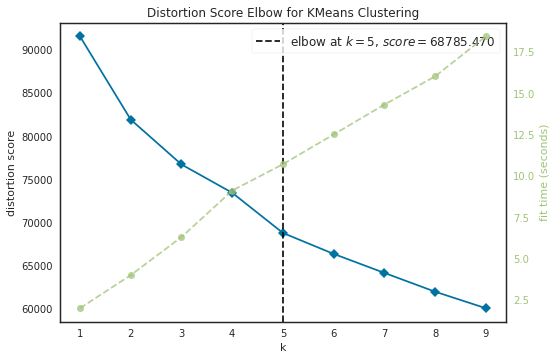

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#Transform Datatype of column names
df.columns = df.columns.astype(str)

# normalize data with MinMaxScaler
mms = MinMaxScaler()
X = df.drop(['customer_id'], axis=1)
X_mms = mms.fit_transform(X)

# reduce dimensionality with PCA
print('Number of features before PCA: {}'.format(len(X_mms[0])))
pca = PCA(.90)
X_pca = pca.fit_transform(X_mms)
print('Number of features after PCA: {}'.format(len(X_pca[0])))

# create a kmeans model
model = KMeans(random_state=42)

# use the KElbowVisualizer to calculate distortion for different numbers of clusters
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X_pca)  
visualizer.show()




In [ ]:
# create a k-means model using optimal number of clusters and assign each customer to a cluster
kmeans_3 = KMeans(n_clusters=5, random_state=42)
prediction = kmeans_3.fit_predict(X_pca)

/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


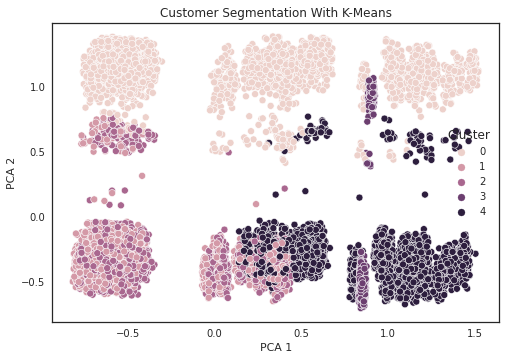

In [ ]:
#Set Seaborn style
sns.set_style("white")

# first PCA component
pca1 = [val[1] for val in X_pca]
# second PCA component
pca2 = [val[2] for val in X_pca]

# add the cluster and PCA components to the dataframe
df_viz['Cluster'] = prediction
df_viz['PCA 1'] = pca1
df_viz['PCA 2'] = pca2

# plot scatter plot
sns.scatterplot(data=df_viz, x='PCA 1', y='PCA 2', hue='Cluster')
plt.title('Customer Segmentation With K-Means')
plt.show()

<Axes: xlabel='Cluster', ylabel='Count'>

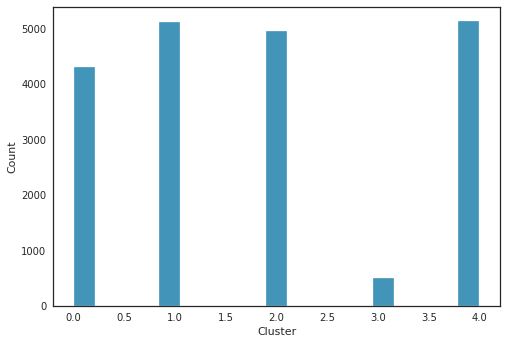

In [ ]:
#Display Number of Customers in each Cluster
sns.histplot(data=df_viz, x ="Cluster")

In [ ]:
#Define numerical variables 
num_var = ["age", "tenure", "past_3_years_bike_related_purchases", "list_price", "standard_cost"]
#Set col and row number for visualization
cols = 3
rows = math.ceil(len(num_var) / cols)
#Set colors
colors = ["#32516e", "#d8a457", "#216758", "#766ea0", "#d05e47"]

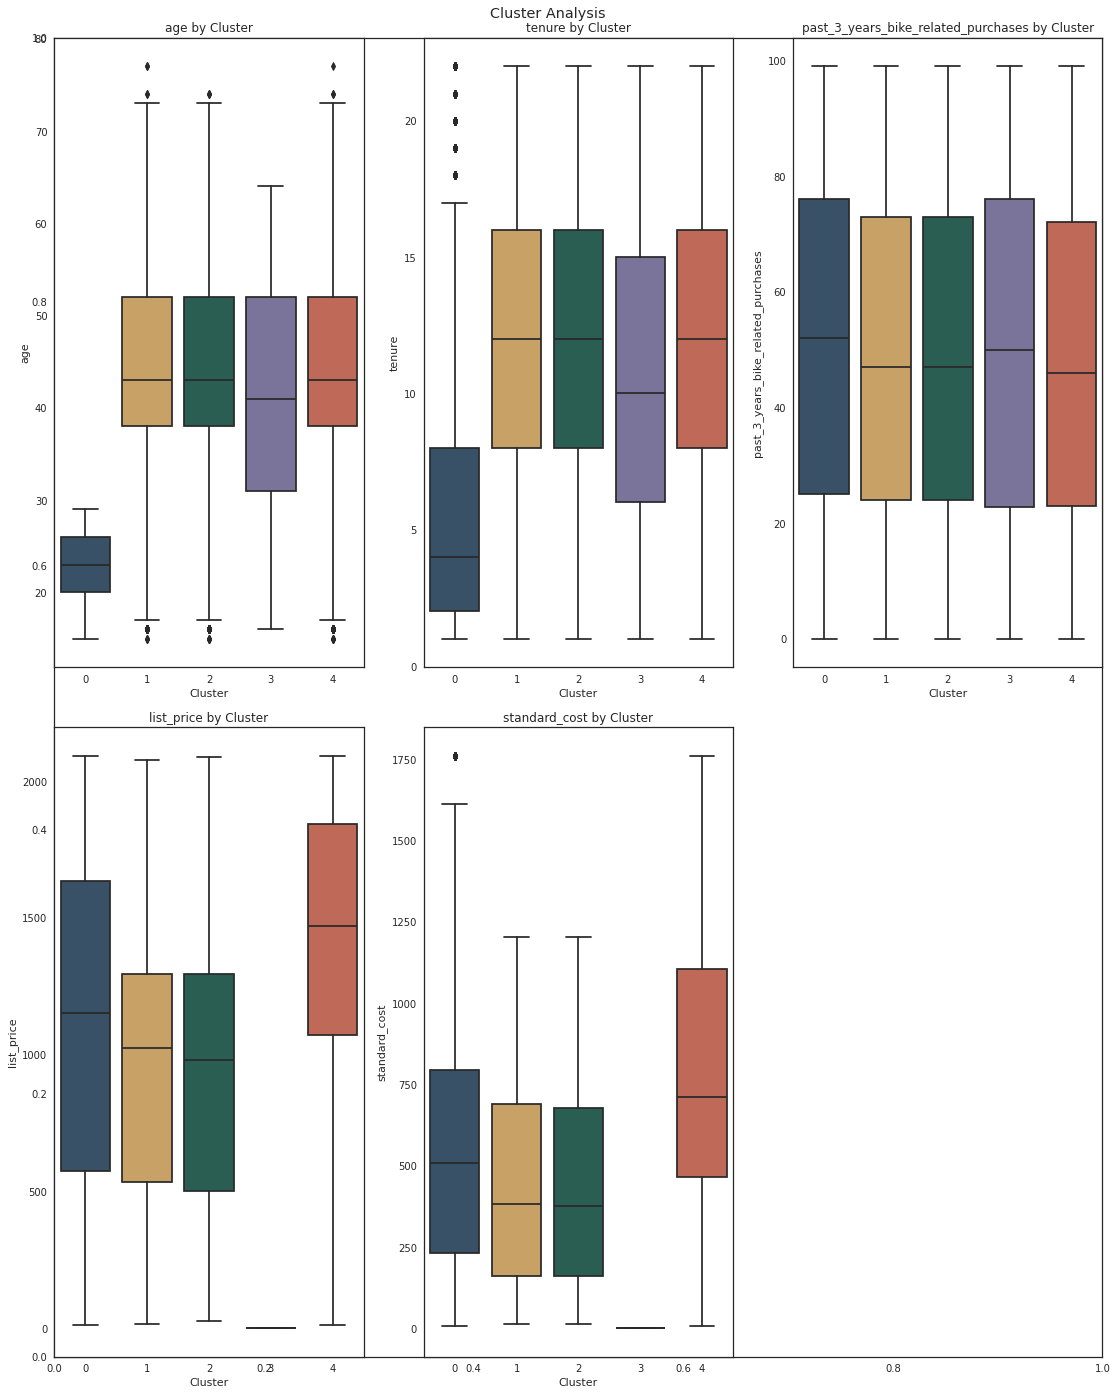

In [ ]:
#Display boxplots for numerical variables
fig, ax = plt.subplots(figsize=(16,20))

for index, key in enumerate(num_var):
    plt.subplot(rows, cols, index + 1) 
    sns.boxplot(x="Cluster", y=key, data=df_viz, palette=sns.color_palette(colors, 5))
    plt.title(f"{key} by Cluster")
plt.suptitle("Cluster Analysis")
plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=None)
plt.tight_layout()
plt.show()

In [ ]:
#Create Function for Stacked Histogram

def bar_chart(var, data): 

    #create Subset
    df_1 = data[["Cluster", var]]
        
    ax = sns.histplot(data=df_1, stat="count", multiple="stack",x="Cluster",hue=var,legend=True,
     palette=sns.color_palette(colors, 5), binwidth=0.5)
    sns.move_legend(ax, "center left", bbox_to_anchor=(1.0, 0.5),ncol=1, title="Legend", frameon=False)


In [ ]:
#Define Categorical Variables
cat_var = ["gender", "owns_car", "job_industry_category", "online_order", "order_status", "product_line", 
    "product_size", "product_class", "Age_Group", "brand", "transaction_date"]
#Set row and col number for visualization
cols = 3
rows = math.ceil(len(cat_var) / cols)

/tmp/ipykernel_12/1815439812.py:16: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.histplot(data=df_1, stat="count", multiple="stack",x="Cluster",hue=var,legend=True,
/tmp/ipykernel_12/1815439812.py:16: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.histplot(data=df_1, stat="count", multiple="stack",x="Cluster",hue=var,legend=True,
/tmp/ipykernel_12/1815439812.py:16: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.histplot(data=df_1, stat="count", multiple="stack",x="Cluster",hue=var,legend=True,
/tmp/ipykernel_12/1815439812.py:16: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.histplot(data=df_1, stat="count", multiple="stack",x="Cluster",hue=var,legend=True,
/tmp/ipykernel_12/1815439812.py:16: UserWarning: The palette list 

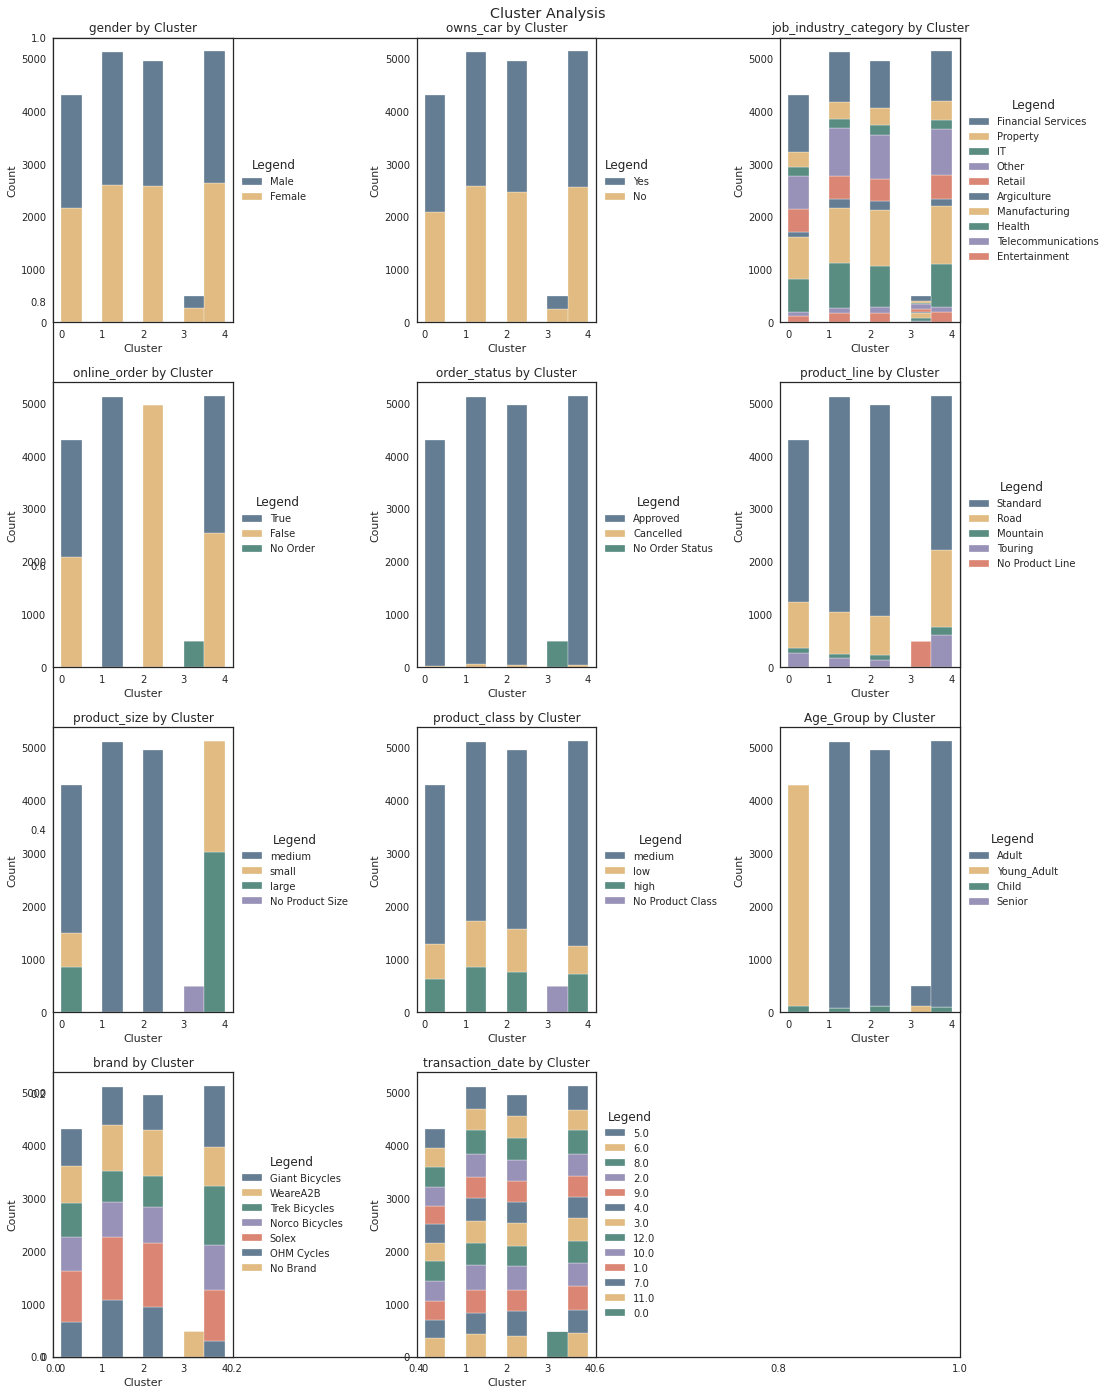

In [ ]:
#Plot Categorical Variables
fig, ax = plt.subplots(figsize=(16,20))

for index, key in enumerate(cat_var):
    plt.subplot(rows, cols, index + 1) 
    bar_chart(key, df_viz)
    plt.title(f"{key} by Cluster")
plt.suptitle("Cluster Analysis")
plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=None)
plt.tight_layout()
plt.show()

### Results

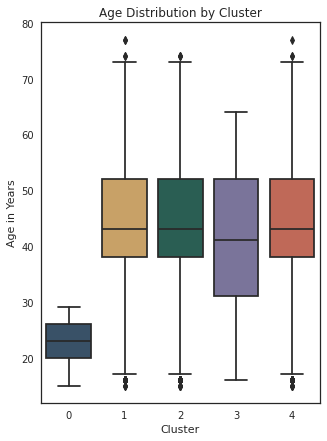

In [ ]:
#Boxplot for Age 
fig = plt.figure(figsize=(5,7))
sns.boxplot(x="Cluster", y="age", data=df_viz, palette=sns.color_palette(colors, 5))
plt.title("Age Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age in Years")
plt.show()

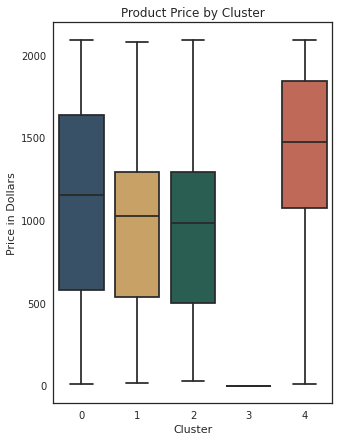

In [ ]:
#Boxplot for Price
fig = plt.figure(figsize=(5,7))
sns.boxplot(x="Cluster", y="list_price", data=df_viz, palette=sns.color_palette(colors, 5))
plt.title("Product Price by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Price in Dollars")
plt.show()

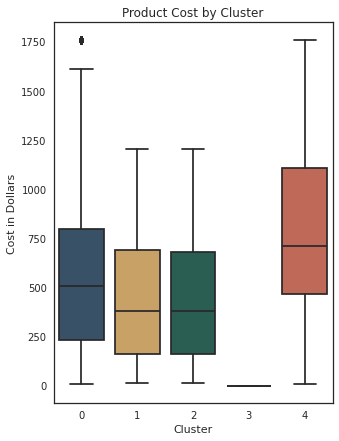

In [ ]:
#Boxplot for Cost 
fig = plt.figure(figsize=(5,7))
sns.boxplot(x="Cluster", y="standard_cost", data=df_viz, palette=sns.color_palette(colors, 5))
plt.title("Product Cost by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cost in Dollars")
plt.show()

/tmp/ipykernel_12/4024146311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["Cluster"] = df_cat["Cluster"].astype(str)
/tmp/ipykernel_12/4024146311.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["Cluster"] = pd.Categorical(df_cat['Cluster'], ['0','1','2','3', '4'])
/tmp/ipykernel_12/4024146311.py:14: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.histplot(data=df_cat, stat="count", multiple="stack",x="Cluster",hue="online_or

Text(0, 0.5, '')

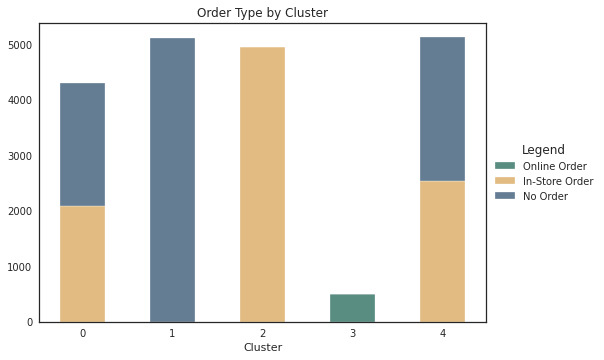

In [ ]:
#Histogram for Online Order
df_cat = df_viz[["Cluster", "online_order"]]
df_cat["Cluster"] = df_cat["Cluster"].astype(str)
df_cat["Cluster"] = pd.Categorical(df_cat['Cluster'], ['0','1','2','3', '4'])

ax = sns.histplot(data=df_cat, stat="count", multiple="stack",x="Cluster",hue="online_order",legend=True,
     palette=sns.color_palette(colors, 5), shrink=0.5)
plt.title("Order Type by Cluster")
ax.legend(["Online Order", "In-Store Order", "No Order"])
sns.move_legend(ax, "center left", bbox_to_anchor=(1.0, 0.5),ncol=1, title="Legend", frameon=False)
plt.xlabel("Cluster")
plt.ylabel("")
